In this project, I took data from Kaggle.com Breast Cancer Histopathological Images to run image classification test to determine wether or not the images contain benign or malignant tumors. I will train the project on the given images and test for accuracy. Once the model is complete we can use it to test future images to determine wether or not the tumor is malignant, i.e. if the patient has breast cancer.

In [73]:
import os, shutil
from keras import models
from keras.models import Model
from keras.layers import Input, Dense
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

np.random.seed(123)

First thing we need to do to start our project and testing is to create train, test and validation data. Once we do this and create our new folders containging these images we can run our testing.

In [74]:
data_benign = 'BreakHist_Dataset/40X/benign-total'
data_malignant = 'BreakHist_Dataset/40X/malignant-total'
new_dir = 'split/'

In [75]:
imgs_benign = [file for file in os.listdir(data_benign) if file.endswith('.png')]

In [76]:
imgs_benign[0:10]

['SOB_B_TA-14-15275-40-010.png',
 'SOB_B_TA-14-15275-40-004.png',
 'SOB_B_TA-14-16184-40-004.png',
 'SOB_B_TA-14-3411F-40-005.png',
 'SOB_B_F-14-14134-40-008.png',
 'SOB_B_TA-14-16184-40-010.png',
 'SOB_B_TA-14-3411F-40-011.png',
 'SOB_B_F-14-25197-40-032.png',
 'SOB_B_TA-14-16184-40-038.png',
 'SOB_B_F-14-9133-40-023.png']

Let's see how many benign and malignant tumor images we have.

In [77]:
print('There are',len(imgs_benign), 'benign images')

There are 625 benign images


In [78]:
imgs_malignant = [file for file in os.listdir(data_malignant) if file.endswith('.png')]

In [79]:
print('There are', len(imgs_malignant), 'malignant images')

There are 1370 malignant images


### Seperate Data

Now we will seperate our data into train, test, and validation folders. We do this in order to run our tests. Some of this code is blocked out because upon the first completeion we created these folders so they already exist. 

In [80]:
#os.mkdir(new_dir)

In [81]:
train_folder = os.path.join(new_dir, 'train')
train_benign = os.path.join(train_folder, 'benign')
train_malignant = os.path.join(train_folder, 'malignant')

test_folder = os.path.join(new_dir, 'test')
test_benign = os.path.join(test_folder, 'benign')
test_malignant = os.path.join(test_folder, 'malignant')

val_folder = os.path.join(new_dir, 'validation')
val_benign = os.path.join(val_folder, 'benign')
val_malignant = os.path.join(val_folder, 'malignant')

In [82]:
train_benign

'split/train/benign'

In [83]:
#os.mkdir(train_folder)
#os.mkdir(train_benign)
#os.mkdir(train_malignant)

#os.mkdir(test_folder)
#os.mkdir(test_benign)
#os.mkdir(test_malignant)

#os.mkdir(val_folder)
#os.mkdir(val_benign)
#os.mkdir(val_malignant)

We will copy the benign images into three subfolders: training, testing, and validating. The training folders will contain 60% of the images, leaving 20% respectively for testing and validating.

In [84]:
#training benign 60% images -->375
imgs = imgs_benign[:375]
for img in imgs:
    origin = os.path.join(data_benign, img)
    destination = os.path.join(train_benign, img)
    shutil.copyfile(origin, destination)

In [85]:
#validation benign 20% images -->125
imgs = imgs_benign[375:500]
for img in imgs:
    origin = os.path.join(data_benign, img)
    destination = os.path.join(val_benign, img)
    shutil.copyfile(origin, destination)

In [86]:
#test benign 20% images -->125
imgs = imgs_benign[500:]
for img in imgs:
    origin = os.path.join(data_benign, img)
    destination = os.path.join(test_benign, img)
    shutil.copyfile(origin, destination)

Here we will print out the number of images we have in each folder to confirm that our numbers are right.

In [87]:
print('There are', len(os.listdir(train_benign)), 'benign images in the training set')
print('There are', len(os.listdir(val_benign)), 'benign images in the validation set')
print('There are', len(os.listdir(test_benign)), 'benign images in the test set')

There are 375 benign images in the training set
There are 125 benign images in the validation set
There are 125 benign images in the test set


We will repreat the steps from above for the malignant data.

In [88]:
#train malignant 60% images --> 822
imgs = imgs_malignant[:822]
for img in imgs:
    origin = os.path.join(data_malignant, img)
    destination = os.path.join(train_malignant, img)
    shutil.copyfile(origin, destination)
    
#validation malignant 20% images --> 274
imgs = imgs_malignant[822:1096]
for img in imgs:
    origin = os.path.join(data_malignant, img)
    destination = os.path.join(val_malignant, img)
    shutil.copyfile(origin, destination)
    
#test malignant 20% images -->274
imgs = imgs_malignant[1096:]
for img in imgs:
    origin = os.path.join(data_malignant, img)
    destination = os.path.join(test_malignant, img)
    shutil.copyfile(origin, destination)


In [89]:
print('There are', len(os.listdir(train_malignant)), 'malignant images in the training set')
print('There are', len(os.listdir(val_malignant)), 'malignant images in the validation set')
print('There are', len(os.listdir(test_malignant)), 'malignant images in the test set')


There are 822 malignant images in the training set
There are 274 malignant images in the validation set
There are 274 malignant images in the test set


### Run Image Classification

Now that our data is seperated we will use Keras to classify our images.

In [90]:
# get all the data in the folder split/test
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(64,64), batch_size = 399)
# get all the data in the folder split/validation
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder, target_size=(64,64), batch_size = 399)
# get all the data in the folder split/train
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_folder, target_size=(64,64), batch_size=1197)

Found 399 images belonging to 2 classes.
Found 399 images belonging to 2 classes.
Found 1197 images belonging to 2 classes.


Below we will create our data sets.

In [91]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [92]:
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 1197
Number of testing samples: 399
Number of validation samples: 399
train_images shape: (1197, 64, 64, 3)
train_labels shape: (1197, 2)
test_images shape: (399, 64, 64, 3)
test_labels shape: (399, 2)
val_images shape: (399, 64, 64, 3)
val_labels shape: (399, 2)


In [93]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(1197, 12288)
(399, 12288)
(399, 12288)


In [94]:
train_y = np.reshape(train_labels[:,0], (1197,1))
test_y = np.reshape(test_labels[:,0], (399,1))
val_y = np.reshape(val_labels[:,0], (399,1))

In [95]:
from keras import models
from keras import layers
np.random.seed(123)
model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(12288,)))
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [96]:
model.compile(optimizer='sgd', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

histoire = model.fit(train_img, 
                     train_y, 
                     epochs=30, 
                     batch_size=32, 
                     validation_data=(val_img, val_y))


Train on 1197 samples, validate on 399 samples
Epoch 1/30
1197/1197 [==============================] - 0s 348us/step - loss: 0.6322 - acc: 0.6775 - val_loss: 0.6315 - val_acc: 0.6867
Epoch 2/30
1197/1197 [==============================] - 0s 111us/step - loss: 0.6143 - acc: 0.6867 - val_loss: 0.6047 - val_acc: 0.6867
Epoch 3/30
1197/1197 [==============================] - 0s 112us/step - loss: 0.5997 - acc: 0.6867 - val_loss: 0.6073 - val_acc: 0.6867
Epoch 4/30
1197/1197 [==============================] - 0s 115us/step - loss: 0.5731 - acc: 0.6901 - val_loss: 0.5867 - val_acc: 0.6867
Epoch 5/30
1197/1197 [==============================] - 0s 99us/step - loss: 0.5680 - acc: 0.7084 - val_loss: 0.6259 - val_acc: 0.6867
Epoch 6/30
1197/1197 [==============================] - 0s 113us/step - loss: 0.5427 - acc: 0.7226 - val_loss: 0.5796 - val_acc: 0.6867
Epoch 7/30
1197/1197 [==============================] - 0s 102us/step - loss: 0.5299 - acc: 0.7343 - val_loss: 0.6203 - val_acc: 0.6867
Ep

In [97]:
results_train = model.evaluate(train_img, train_y)

1197/1197 [==============================] - 0s 38us/step


In [98]:
results_test = model.evaluate(test_img, test_y)

399/399 [==============================] - 0s 51us/step


In [99]:
results_train

[0.5100175721902298, 0.7142857143106118]

In [100]:
results_test

[0.5886111538063613, 0.674185463957918]

As we see in our results above, our training accuracy ia 83% leading to our testing accuracy being 74%. These is a decent accuracy with the number of images we have, but we will want to be much more accurate when diagnosing patients. 

In [29]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [51]:
history = model.fit(train_images,
                    train_y,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_images, val_y))

Train on 1197 samples, validate on 399 samples
Epoch 1/30
1197/1197 [==============================] - 5s 4ms/step - loss: 0.4757 - acc: 0.7937 - val_loss: 0.5074 - val_acc: 0.8020
Epoch 2/30
1197/1197 [==============================] - 5s 4ms/step - loss: 0.4933 - acc: 0.7870 - val_loss: 0.5873 - val_acc: 0.6942
Epoch 3/30
1197/1197 [==============================] - 5s 4ms/step - loss: 0.4560 - acc: 0.8095 - val_loss: 0.6916 - val_acc: 0.6867
Epoch 4/30
1197/1197 [==============================] - 5s 4ms/step - loss: 0.4706 - acc: 0.7928 - val_loss: 0.5099 - val_acc: 0.7970
Epoch 5/30
1197/1197 [==============================] - 5s 4ms/step - loss: 0.4678 - acc: 0.8020 - val_loss: 0.5341 - val_acc: 0.7820
Epoch 6/30
1197/1197 [==============================] - 5s 4ms/step - loss: 0.4641 - acc: 0.8028 - val_loss: 0.4975 - val_acc: 0.8120
Epoch 7/30
1197/1197 [==============================] - 5s 4ms/step - loss: 0.4581 - acc: 0.8045 - val_loss: 0.5807 - val_acc: 0.7043
Epoch 8/30
1197

In [52]:
results_train = model.evaluate(train_images, train_y)

1197/1197 [==============================] - 1s 1ms/step


In [53]:
results_test = model.evaluate(test_images, test_y)

399/399 [==============================] - 1s 1ms/step


In [54]:
results_train

[0.4098094732141933, 0.837092732028754]

In [55]:
results_test

[0.5162323520595866, 0.7694235591960132]

After adding layers, our training results decreased to 84% and our test reults our now 77% accurate. These accuracies are lower than before but our more similar to each other. 

In [56]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

### Checking our test:

Below we will run images to see how accurate we were in classifing our images.

In [57]:
classifier = Sequential()
classifier.add(Convolution2D(32, 3, 3, input_shape=(64,64,3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Flatten())

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(64, 64, 3..., activation="relu")`
  


In [58]:
import numpy as np
from keras.preprocessing import image
import random, os

test_image = image.load_img('split/test/benign/SOB_B_A-14-22549AB-40-001.png', target_size = (64,64))

test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = classifier.predict(test_image)
#train_generator.class_indicies

if result[0][0] == 0:
    prediction = 'benign'
else:
    prediction = 'malignant'
print(prediction)

benign


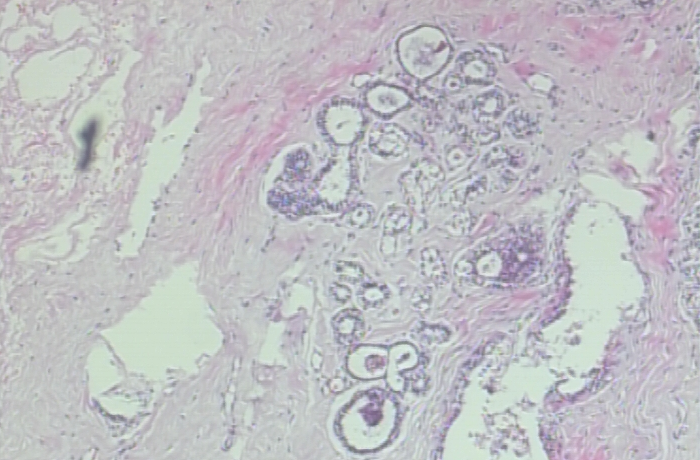

In [59]:
from IPython.display import Image
Image('split/test/benign/SOB_B_A-14-22549AB-40-001.png')

In [60]:
test_image = image.load_img('split/test/benign/SOB_B_A-14-22549AB-40-002.png', target_size = (64,64))

test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = classifier.predict(test_image)
#train_generator.class_indicies

if result[0][0] == 0:
    prediction = 'benign'
else:
    prediction = 'malignant'
print(prediction)

benign


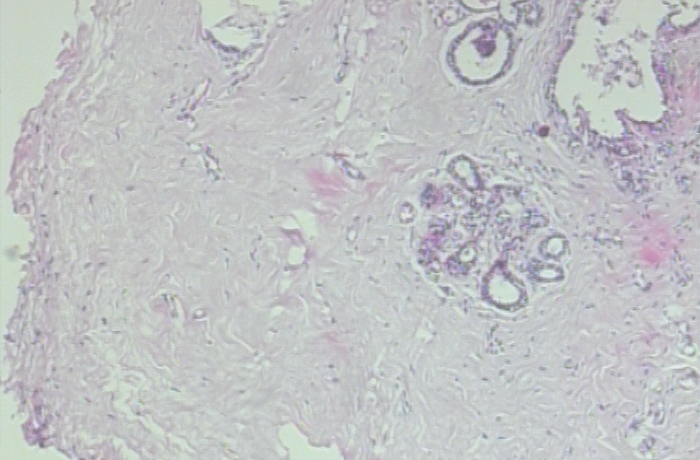

In [61]:
from IPython.display import Image
Image('split/test/benign/SOB_B_A-14-22549AB-40-002.png')

In [62]:
test_image = image.load_img('split/test/benign/SOB_B_A-14-22549AB-40-003.png', target_size = (64,64))
#test_image = random.choice([x for x in os.listdir('split/test.png')
              # if os.path.isfile(os.path.join('split/test', x))])
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = classifier.predict(test_image)
#train_generator.class_indicies

if result[0][0] == 0:
    prediction = 'benign'
else:
    prediction = 'malignant'
print(prediction)

benign


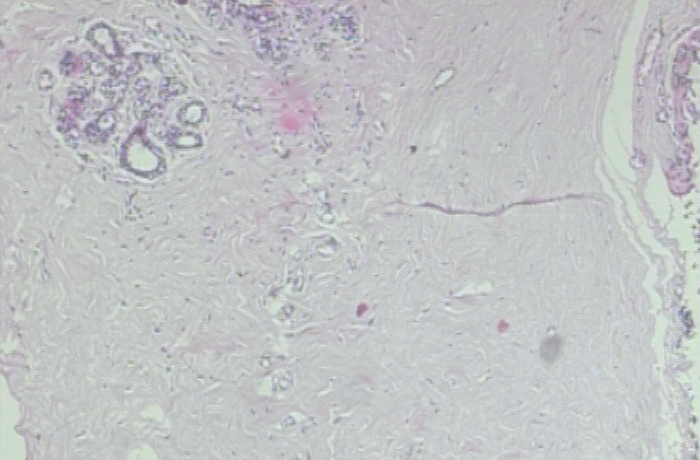

In [63]:
from IPython.display import Image
Image('split/test/benign/SOB_B_A-14-22549AB-40-003.png')

In [64]:
test_image = image.load_img('split/test/malignant/SOB_M_DC-14-11031-40-006.png', target_size = (64,64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = classifier.predict(test_image)
#train_generator.class_indicies

if result[0][0] == 0:
    prediction = 'benign'
else:
    prediction = 'malignant'
print(prediction)

benign


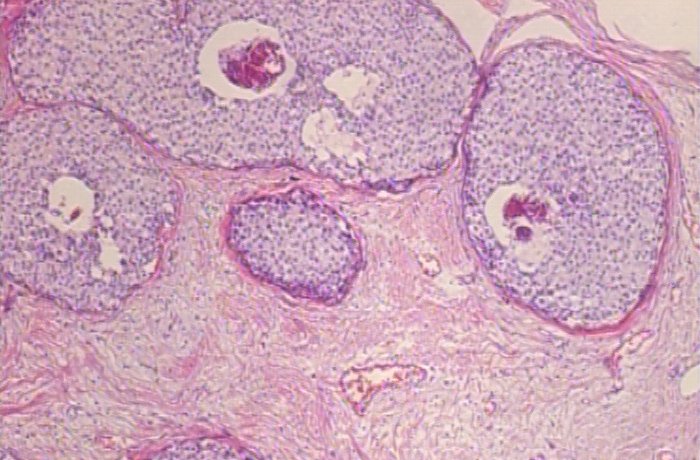

In [65]:
from IPython.display import Image
Image('split/test/malignant/SOB_M_DC-14-11031-40-006.png')

This is incorrect, this is a malignant image but ran through as benign.

In [66]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('split/test/malignant/SOB_M_DC-14-11031-40-002.png', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
train_generator.class_indices

if result[0][0] == 1:
    prediction = 'benign'
else:
    prediction = 'malignant'
print(prediction)
    
       


malignant


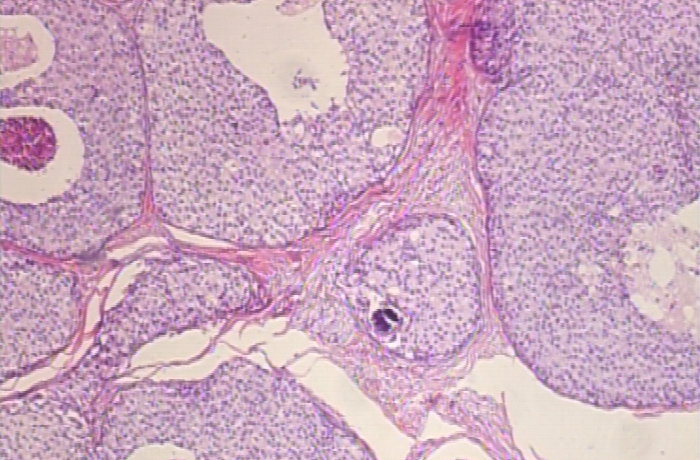

In [67]:
from IPython.display import Image
Image('split/test/malignant/SOB_M_DC-14-11031-40-002.png')

In [68]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('split/test/malignant/SOB_M_DC-14-11031-40-012.png', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
train_generator.class_indices

if result[0][0] == 1:
    prediction = 'benign'
else:
    prediction = 'malignant'
print(prediction)

malignant


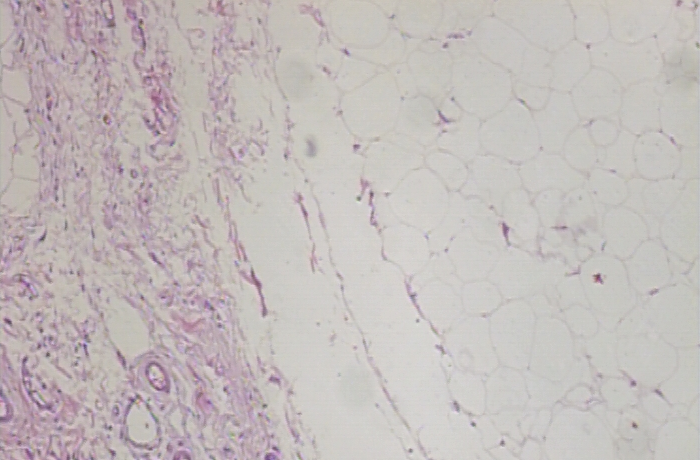

In [69]:
from IPython.display import Image
Image('split/test/malignant/SOB_M_DC-14-11031-40-012.png')

In [70]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('split/test/malignant/SOB_M_DC-14-11031-40-013.png', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
train_generator.class_indices

if result[0][0] == 1:
    prediction = 'benign'
else:
    prediction = 'malignant'
print(prediction)

malignant


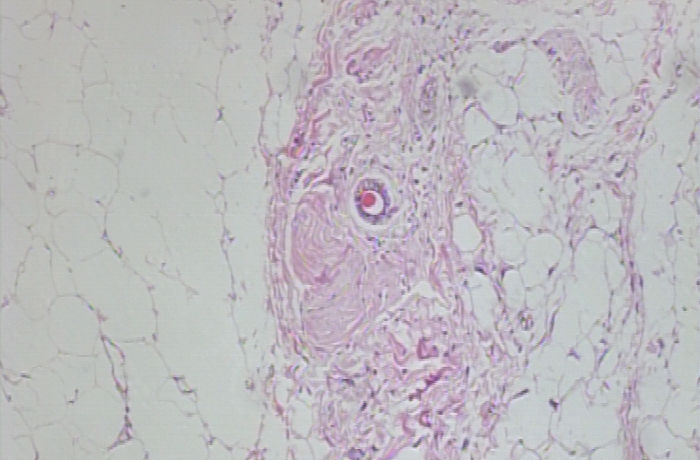

In [71]:
from IPython.display import Image
Image('split/test/malignant/SOB_M_DC-14-11031-40-013.png')

After testing, we saw that out of 7 images (4 malignant & 3 benign) the images were classified correctly 6 of 7 times (86%). 